In [1]:
import onnx
import onnxruntime
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load ONNX
## check onnx API

In [2]:
onnx_model = onnx.load("./RF_trained_power.onnx")
onnx.checker.check_model(onnx_model)

## test model using onnxruntime

In [3]:
ort_session = onnxruntime.InferenceSession("./RF_trained_power.onnx")
# input 
x = np.random.rand(1,9).astype(dtype = 'float32') # random generated here - use your inputs!
ort_inputs = {ort_session.get_inputs()[0].name: x}
ort_outputs = ort_session.run(None, ort_inputs)[0]
ort_outputs

2022-04-22 19:43:59.847710 [W:onnxruntime:, execution_frame.cc:811 VerifyOutputSizes] Expected shape from model of {,1} does not match actual shape of {1,23} for output variable


array([[ 1.4572638e-03,  4.4865604e-03,  9.4563076e-03,  1.8118961e-02,
         2.5140179e-02,  3.8290180e-02,  4.4017646e-02,  6.1020870e-02,
         5.9303902e-02,  7.0108235e-02,  8.7139197e-02,  1.0159073e-01,
         1.0581519e-01,  1.0109690e-01,  7.4220024e-02,  4.5666751e-01,
         6.4241272e-01,  2.9342091e-01,  1.3146099e-01,  1.2682732e-02,
        -1.1577507e-04, -8.6752734e-05, -1.7504800e-07]], dtype=float32)

# Example
## load test data

In [4]:
data = pd.read_csv("./hypercube_ecrit_filtered_80-20_split_5folds.csv")
train_val = data[data['split']!="TEST"]
test_data = data[data['split'] == 'TEST']

## normalize the test data 
input_features = ['B0_eqdsk', 'R0_eqdsk', 'ate0', 'dense0', 'elecfld', 'lh_npara1', 'lh_power', 'zeff', 'ip_scale']
scaler = StandardScaler() 
X = scaler.fit_transform(train_val[input_features])
X_test = scaler.transform(test_data[input_features])
output_features =  ['powers_' + str(i) for i in range(23)]
Y_test = np.array(test_data[output_features])

## output prediction and inference time

2022-04-22 19:44:00.241793 [W:onnxruntime:, execution_frame.cc:811 VerifyOutputSizes] Expected shape from model of {,1} does not match actual shape of {2670,23} for output variable


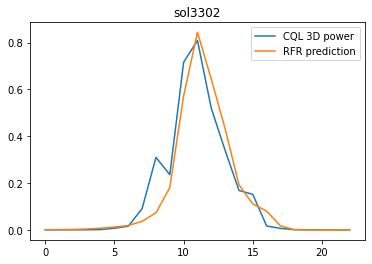

MSE value:  0.004989656067597773


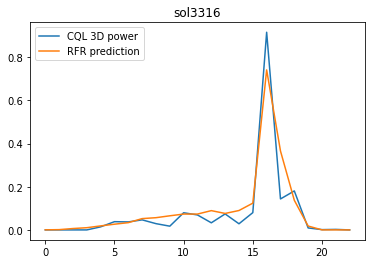

MSE value:  0.00409116116930515


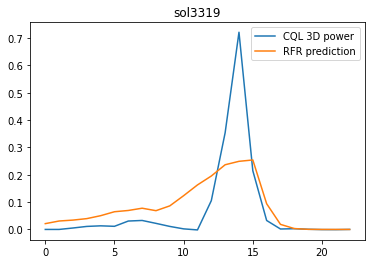

MSE value:  0.013524731550536037


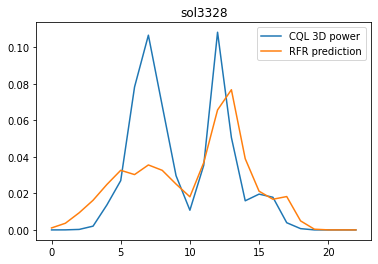

MSE value:  0.0005393931655486365


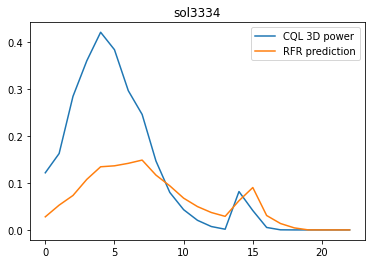

MSE value:  0.013625358050182322


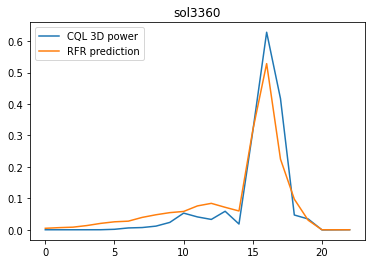

MSE value:  0.0026258469513305745


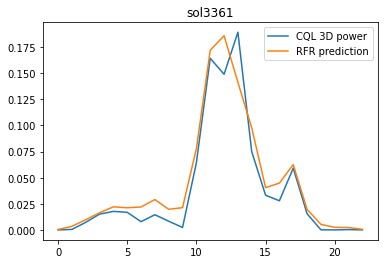

MSE value:  0.0002508462737269346


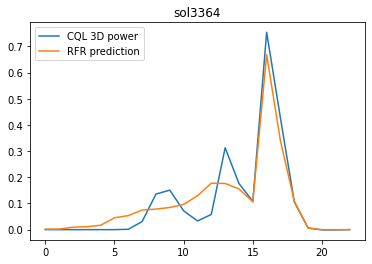

MSE value:  0.003167922584181165


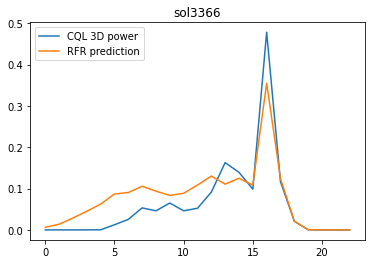

MSE value:  0.0020345478807179953


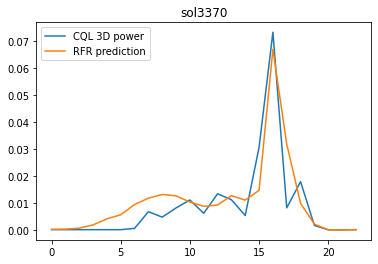

MSE value:  5.2933626010918155e-05
Averaged inferece time:  9.641427485306278e-08


In [5]:
# import input data and run onnx model
t0 = timer()
ort_inputs = {ort_session.get_inputs()[0].name: X_test.astype(dtype = 'float32')} 
# output predition for all test records
ort_outputs = ort_session.run(None, ort_inputs)[0]
t_elapsed = (timer() - t0) / len(Y_test)

# plot predictions
for index in range(10):
    y_true = Y_test[index]
    y_pred = ort_outputs[index]   
    plt.figure()
    plt.title(test_data.iloc[index]['sol'])
    plt.plot(y_true)
    plt.plot(y_pred)
    plt.legend(['CQL 3D power', 'RFR prediction'])
    plt.show()    
    print('MSE value: ', mean_squared_error(y_true, y_pred))
print('Averaged inferece time: ', t_elapsed / len(Y_test))